In [1]:
import pandas as pd
import numpy  as np

import pickle
 
from pathlib import Path


import statsmodels.api as sm

import matplotlib.pyplot as plt


import sys
sys.path.append("D:/analyze_Pearson_residuals")

from  plot_tab_utilities import *



pd.set_option('display.max_columns', 5)

In [2]:
#### user specified
data_folder = r"D:/analyze_Pearson_residuals/"

data_subfolder = "10k_heart"

data_path = Path ( data_folder + data_subfolder )

In [3]:
# output plots
Ag_plot_jpg = data_subfolder + "_Figure_2.jpg"
Lg_plot_jpg = data_subfolder + "_Figure_4.jpg"  
Sg_plot_jpg = data_subfolder + "_Figure_6.jpg"


# input data
nru_dict_pkl =  "nru_dict.pkl"
scanpy_variance_pkl = "residual_variance_scanpy.pkl"
SCT_variance_pkl = "SCT_v2_residual_variance.pkl"
Ag_complementary_pkl = "Ag_complementary_samples.pkl"
Lg_complementary_pkl = "Lg_complementary_samples.pkl"
Sg_complementary_pkl = "Sg_complementary_samples.pkl"
 


# paths: output plots
Ag_plot_dsn = data_path / Ag_plot_jpg
Lg_plot_dsn = data_path / Lg_plot_jpg
Sg_plot_dsn = data_path / Sg_plot_jpg

# paths: input data
nru_dict_dsn = data_path / nru_dict_pkl
scanpy_variance_dsn = data_path / scanpy_variance_pkl
SCT_variance_dsn = data_path / SCT_variance_pkl
Ag_complementary_dsn = data_path / Ag_complementary_pkl
Lg_complementary_dsn = data_path / Lg_complementary_pkl
Sg_complementary_dsn = data_path / Sg_complementary_pkl

In [4]:
def plot_tab ( df_analy, method_symbol, method_label, plot_jpg_dsn ):

  df_analy['ratio'] = df_analy[1]/ df_analy[0]
  df_analy['abs_log_ratio'] = np.abs ( np.log10 ( df_analy['ratio'] ) ) 
 
  df_analy['rank_stat'] = df_analy['stat'].rank ( ascending=False )
  df_analy['rank_0'] = df_analy[0].rank ( ascending=False )
  df_analy['rank_1'] = df_analy[1].rank ( ascending=False )

  df_analy['group_0'] = pd.cut ( df_analy['rank_0'], bins, labels=labels )
  df_analy['group_1']   = pd.cut ( df_analy['rank_1'], bins, labels=labels )
 
  xtab_in = df_analy.rename( columns={'group_0':'S', 'group_1':'S_tilde'} )
  pti = pv_table_noprint_margins ( xtab_in, 'S', 'S_tilde' )


  rank_stat_200 = df_analy['stat'].loc [ df_analy['rank_stat'] == 200 ].max()
  print (  '\n\n genes rank_stat_200: ', rank_stat_200 )  

  arr_unreliability = df_analy['unreliability'].values
  x = np.log10 ( arr_unreliability )
  y = df_analy['abs_log_ratio'].values

  x = sm.add_constant(x)  
  result = sm.OLS(y, x).fit()
  print( '\n\n', result.summary() )

  max_unreliability = np.max ( arr_unreliability )
  max_log10_unreliability = np.log10 ( max_unreliability )  
  ypred_x_max = result.predict( [1, max_log10_unreliability] )
  ypred_x_min = result.predict( [1, 0] )
 
  fig, (ax1, ax2, ax3 )  = plt.subplots(1,3, figsize=( 8., 3. ) )

  plot_ax ( df_analy, ax1, 'A', 0, 1, 'sample S', 'sample $\~S$'  )
  
  plot_ax ( df_analy, ax2, 'B', 'stat', 'abs_log_ratio', method_label, 'abs ( log$_1$$_0$ ( ' + method_symbol + '($\~S$) / ' + method_symbol + '(S) ) )' , yscale_log=False, line_slope='none' )
  ax2.axvline ( rank_stat_200,  linewidth=1, color='red') 
  y_min2, y_max2 = ax2.get_ylim()

  plot_ax ( df_analy, ax3, 'C', 'unreliability', 'abs_log_ratio', 'unreliability ratio: ' + "$M_g$" + '/' + "$A_g$", \
  'abs ( log$_1$$_0$ ( ' + method_symbol + '($\~S$) / ' + method_symbol + '(S) ) )' , yscale_log=False, line_slope='none' )
  ax3.plot ( [ 1, max_unreliability ], [ ypred_x_min, ypred_x_max ], linewidth=1, color='red')  
  y_min3, y_max3 = ax3.get_ylim()   
 
  y_min = min ( y_min2, y_min3 )
  y_max = max ( y_max2, y_max3 )
  ax2.set_ylim ( y_min, y_max )
  ax3.set_ylim ( y_min, y_max ) 
    
    
  plt.subplots_adjust( wspace=0.3, bottom=0.2 )
  plt.savefig(  plot_jpg_dsn, transparent=True, dpi=300 )  
    
  return pti

In [5]:
pctl_list = [.01,.05, .10, .25, .5, .75, .90, .95, .99 ]


bins = [ 0, 20, 50, 100, 200, 500, 2000, 1e6]
labels = ['1-20', '21-50', '51-100', '101-200', '201-500','501-2000', '2001+']

In [6]:
f = open( nru_dict_dsn, 'rb' )    
nru_dict = pickle.load(f)           
f.close()       


df_unreliability = nru_dict['df_gene_stats'] [['A_g', 'M_g']]
df_unreliability = df_unreliability.assign( unreliability = df_unreliability['M_g'] / df_unreliability['A_g'] )
print ( ' df_unreliability:  ' )
print ( '\n', df_unreliability )
print ( '\n\n df_unreliability.describe' )
print ( df_unreliability[['unreliability']].describe ( percentiles=pctl_list ) )


df_A_g = nru_dict['df_gene_stats'] [['A_g']].rename( columns={'A_g':'stat'} )
print ( '\n\n df_A_g:  ' )
print ( '\n', df_A_g )

 
df_L_g = pd.read_pickle ( scanpy_variance_dsn )[['CLIPPED']].rename( columns={'CLIPPED':'stat'} )
print ( '\n\n df_L_g:  ' )
print ( '\n', df_L_g )


df_S_g = pd.read_pickle ( SCT_variance_dsn ).rename( columns={'residual_variance':'stat'} )
print ( '\n\n df_S_g:  ' )
print ( '\n', df_S_g )

 df_unreliability:  

                             A_g          M_g  unreliability
ENSMUSG00000052305  5431.424034  5632.169642       1.036960
ENSMUSG00000069919  1391.789121  1465.445393       1.052922
ENSMUSG00000073940  1383.160300  1444.191949       1.044125
ENSMUSG00000069917   971.366465  1017.600302       1.047597
ENSMUSG00000038791   603.920335  1390.212454       2.301980
...                         ...          ...            ...
ENSMUSG00000020905     0.443594     0.611757       1.379092
ENSMUSG00000027313     0.443594     0.580312       1.308204
ENSMUSG00000104861     0.443594     0.552270       1.244989
ENSMUSG00000041144     0.443594     0.650507       1.466445
ENSMUSG00000000154     0.443594     0.535058       1.206189

[14472 rows x 3 columns]


 df_unreliability.describe
       unreliability
count   14472.000000
mean        1.252425
std         0.883998
min         1.000000
1%          1.035661
5%          1.049923
10%         1.059652
25%         1.083851
50%         1


  A_g


 df_complementary_stats_Ag

                               0            1
ENSMUSG00000052305  5208.486373  5608.134244
ENSMUSG00000069919  1329.721724  1458.043311
ENSMUSG00000073940  1250.993918  1319.291278
ENSMUSG00000069917   928.176768  1023.889410
ENSMUSG00000041616   329.695291   423.864138
...                         ...          ...
ENSMUSG00000062012     0.504761     0.538549
ENSMUSG00000085395     0.504761     0.568420
ENSMUSG00000025271     0.504761     0.538836
ENSMUSG00000042429     0.504761     0.569003
ENSMUSG00000037455     0.504761     0.477444

[12995 rows x 2 columns]


 genes rank_stat_200:  10.657347169264263


                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     2061.
Date:                Tue, 11 Jul 

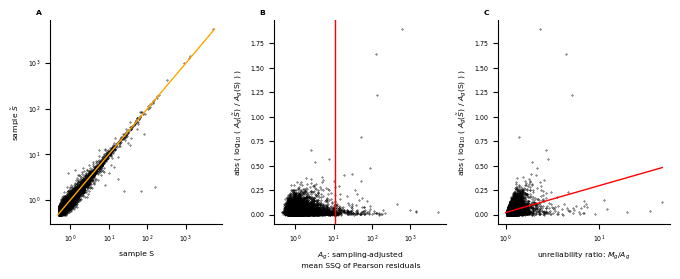

In [7]:
print ( '\n  A_g' )  
df_complementary_stats_Ag = pd.read_pickle ( Ag_complementary_dsn )  
print ( '\n\n df_complementary_stats_Ag' )
print ( '\n', df_complementary_stats_Ag )  

df_A_g_UR = pd.concat ( [ df_A_g[['stat']], df_unreliability[['unreliability']] ], axis=1 )
df_stats_Ag = df_A_g_UR.merge ( df_complementary_stats_Ag, how='inner', left_index=True, right_index=True )
pti = plot_tab ( df_stats_Ag, "$A_g$", '$A_g$: sampling-adjusted \n mean SSQ of Pearson residuals',  Ag_plot_dsn ) 
print ( '\n\n Table 3' )
pd.set_option('display.max_columns', 8)
print ( '\n', pti )  
pd.set_option('display.max_columns', 5)


  L_g


 df_complementary_stats_Lg

                              0           1
ENSEMBL_ID                                
ENSMUSG00000052305  563.918005  538.091370
ENSMUSG00000069919  435.447142  413.672813
ENSMUSG00000069917  397.902680  387.781072
ENSMUSG00000073940  242.065292  252.862804
ENSMUSG00000013936  103.222378   97.025613
...                        ...         ...
ENSMUSG00000049904    0.537811    0.592265
ENSMUSG00000021763    0.536981    0.695864
ENSMUSG00000097239    0.529520    0.639579
ENSMUSG00000037703    0.524249    1.772005
ENSMUSG00000037455    0.503722    0.476033

[12995 rows x 2 columns]


 genes rank_stat_200:  11.109414416124658


                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     4304.
Date:         

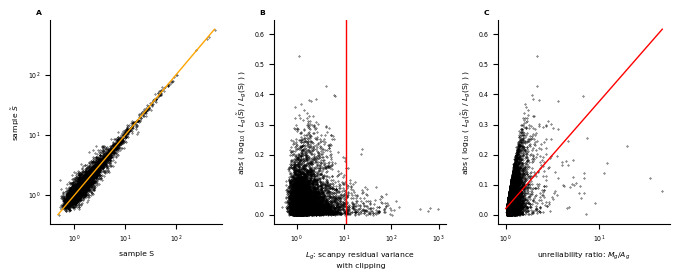

In [8]:
print ( '\n  L_g' )  
df_complementary_stats_Lg = pd.read_pickle ( Lg_complementary_dsn )  
print ( '\n\n df_complementary_stats_Lg' )
print ( '\n', df_complementary_stats_Lg )  

df_L_g_UR = pd.concat ( [ df_L_g[['stat']], df_unreliability[['unreliability']] ], axis=1 )
df_stats_Lg = df_L_g_UR.merge ( df_complementary_stats_Lg, how='inner', left_index=True, right_index=True )
pti = plot_tab ( df_stats_Lg,  "$L_g$", '$L_g$: scanpy residual variance \n with clipping', Lg_plot_dsn ) 
print ( '\n\n Table 5' )
pd.set_option('display.max_columns', 8)
print ( '\n', pti )  
pd.set_option('display.max_columns', 5)


  S_g


 df_complementary_stats_Sg

                             0          1
gene_vector                             
ENSMUSG00000000001   0.643577   0.674521
ENSMUSG00000000028   0.956653   0.911658
ENSMUSG00000000031  36.894753  41.702735
ENSMUSG00000000037   0.261762   0.316140
ENSMUSG00000000056   1.029336   0.930824
...                       ...        ...
ENSMUSG00000116858   0.647649   0.615864
ENSMUSG00000116883   0.742559   0.722968
ENSMUSG00000116895   0.301955   0.365790
ENSMUSG00000116951   1.678848   1.589874
ENSMUSG00000116953   0.498503   0.405890

[12995 rows x 2 columns]


 genes rank_stat_200:  13.587262382935313


                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     4318.
Date:                Tue, 11 Jul 2023   

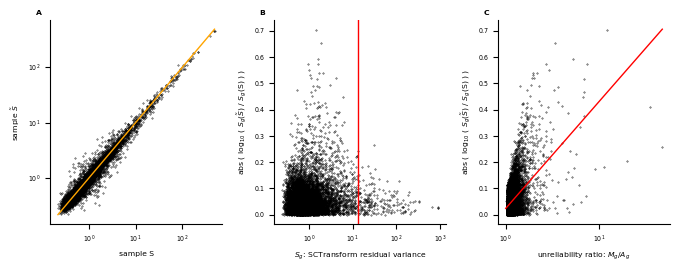

In [9]:
print ( '\n  S_g' )  
df_complementary_stats_Sg = pd.read_pickle ( Sg_complementary_dsn ).set_index ( ['gene_vector'] ).rename( columns={'0':0, '1':1 } )
print ( '\n\n df_complementary_stats_Sg' )
print ( '\n', df_complementary_stats_Sg ) 
 
df_S_g_UR = pd.concat ( [ df_S_g[['stat']], df_unreliability[['unreliability']] ], axis=1 )
df_stats_Sg = df_S_g_UR.merge ( df_complementary_stats_Sg, how='inner', left_index=True, right_index=True )
pti = plot_tab ( df_stats_Sg,  "$S_g$" , '$S_g$: SCTransform residual variance', Sg_plot_dsn ) 
print ( '\n\n Table 7' )
pd.set_option('display.max_columns', 8)
print ( '\n', pti )  
pd.set_option('display.max_columns', 5)